# Bliblioteca

In [130]:
import datetime
import inflection
import math
import pickle
import random
import warnings

import pandas   as pd
import numpy    as np
import seaborn  as sns
import xgboost  as xgb 

from matplotlib            import pyplot as plt

from scipy                 import stats
from IPython.core.display  import HTML
from matplotlib.gridspec   import GridSpec
from tabulate              import tabulate
from IPython.display       import Image

from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

warnings.filterwarnings( 'ignore' )

## 0.1 Helper functions

In [109]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )


def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )
     
    
def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )

    
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).as_matrix()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

sns.set(rc={'figure.figsize':(25,12)})


## 0.2 loading data

In [152]:
# Imports data
df_sales_raw = pd.read_csv( 'datasets/train.csv', low_memory=False ) # Data sets de treino
df_store_raw = pd.read_csv( 'datasets/store.csv', low_memory=False ) # Data sets de lojas

# Merge
df_raw = pd.merge(df_sales_train, df_sales_store, how='left', on='Store' ) # Merge da esquerda para direita

# 1.0. PASSO 1 - Descrição dos dados

In [153]:
df1 = df_raw.copy() # Copia dos dados de df_raw para df1

## 1.1. Renomeando as colunas

In [150]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

In [8]:
snakecase = lambda x: inflection.underscore( x ) # inflection converte a letra maiscula em minuscula, acrescentando '_' entre os intervalos
cols_new = list( map( snakecase, cols_old ) )

# rename
df1.columns = cols_new

## 1.2. Dimensão dos dados

In [9]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) ) #Mostra o numero de linhas
print( 'Number of cols: {}'.format( df1.shape[1] ) ) #Mostra o numero de colunas

Number of Rows: 1017209
Number of cols: 18


## 1.3. Tipo dos dados

In [10]:
df1.dtypes #Visualizando o tipo das colunas

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [11]:
df1['date'] = pd.to_datetime( df1['date'] ) # Transformacao do tipo da coluna - No caso "Date"
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [12]:
df1.isna().sum() #check isna

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [13]:
df1['competition_distance'].max() #Verifcando qual é a distância maxima de uma loja para outra

75860.0

## 1.5. Fillout NA

In [14]:
# Removendo NA usando lambda

# competition_distance
df1[ 'competition_distance' ] = df1[ 'competition_distance' ].apply( lambda x: 200000.0 if math.isnan( x ) else x )
# competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month']) else x['competition_open_since_month'], axis=1 )
# competition_open_since_year
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year']) else x['competition_open_since_year'], axis=1 )
# promo2_since_week             
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week']) else x['promo2_since_week'], axis=1 )
# promo2_since_year         
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year']) else x['promo2_since_year'], axis=1 )

# Criando uma Coluna Mes, e substituindo NA por 0
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dez'}

df1['promo_interval'].fillna(0, inplace=True ) #Foi substituido NA por 0, nao retornando nenhum valor

df1['month_map'] = df1['date'].dt.month.map( month_map ) #Transforma em data / mes / depois substitui os numeros por letras

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1 )


## 1.6. Tipos de alteração

In [15]:
# Modificando o tipo dos dados por colunas
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year' ] = df1['competition_open_since_year' ].astype(int)
df1['promo2_since_week']            = df1['promo2_since_week']           .astype(int)
df1['promo2_since_year']            = df1['promo2_since_year']           .astype(int)


## 1.7. Descrições estaticas 

In [16]:
### Numerical attributes / selecao de atributos
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

In [17]:
# Central tendency - Mean, Median
ct1 = pd.DataFrame( num_attributes.apply( np.mean)   ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median) ).T

# Dispersion - sts, min, max, range, skew, kurtosis

d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']


In [18]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


## 1.7.2 Categorical attributes

In [19]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

In [20]:
cat_attributes.dtypes

state_holiday     object
store_type        object
assortment        object
promo_interval    object
month_map         object
dtype: object

<AxesSubplot:xlabel='assortment', ylabel='sales'>

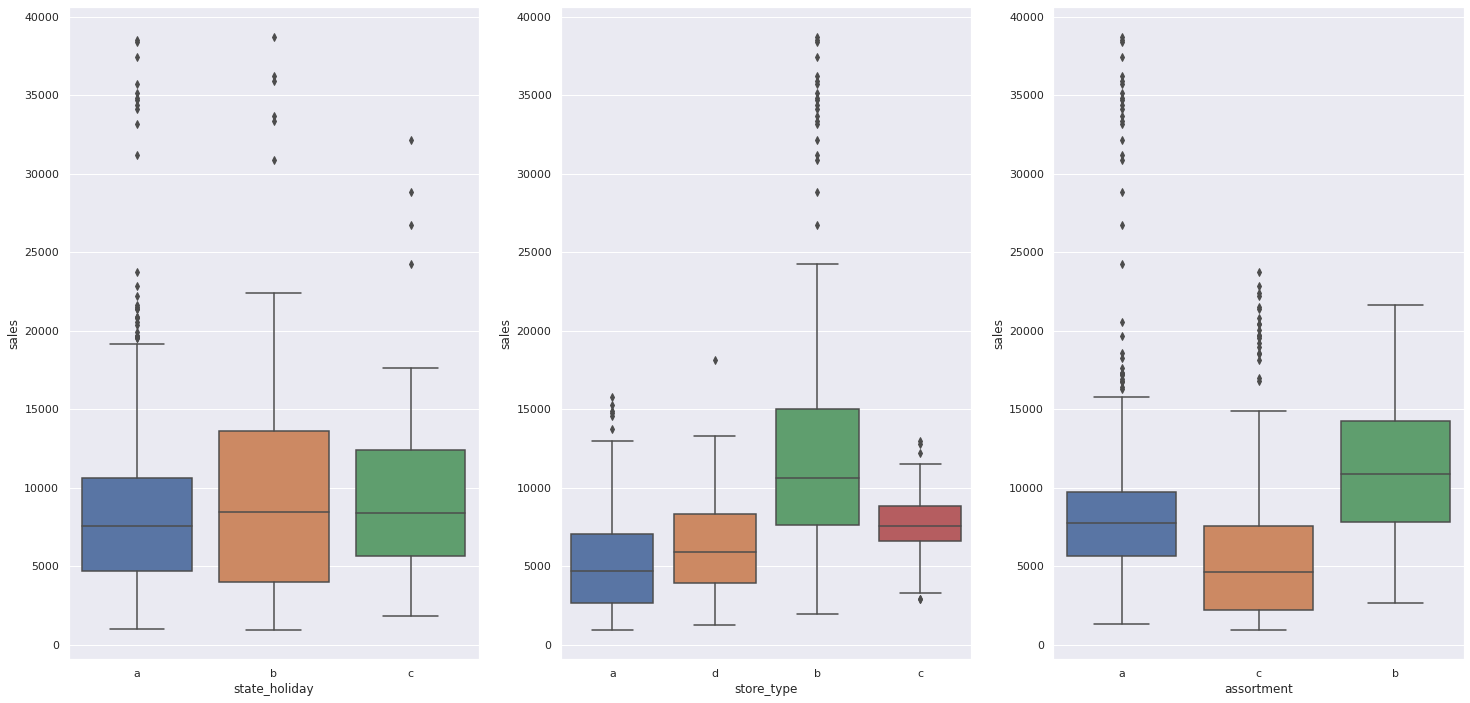

In [21]:
aux1 = df1[ (df1['state_holiday'] !='0' ) & ( df1['sales'] > 0 ) ]

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data = aux1 )

plt.subplot( 1, 3, 2)
sns.boxplot( x='store_type', y='sales', data = aux1 )

plt.subplot( 1, 3, 3)
sns.boxplot( x='assortment', y='sales', data = aux1 )



In [22]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


# 2.0. PASSO 2 - Feature engineering

In [23]:
df2 = df1.copy()

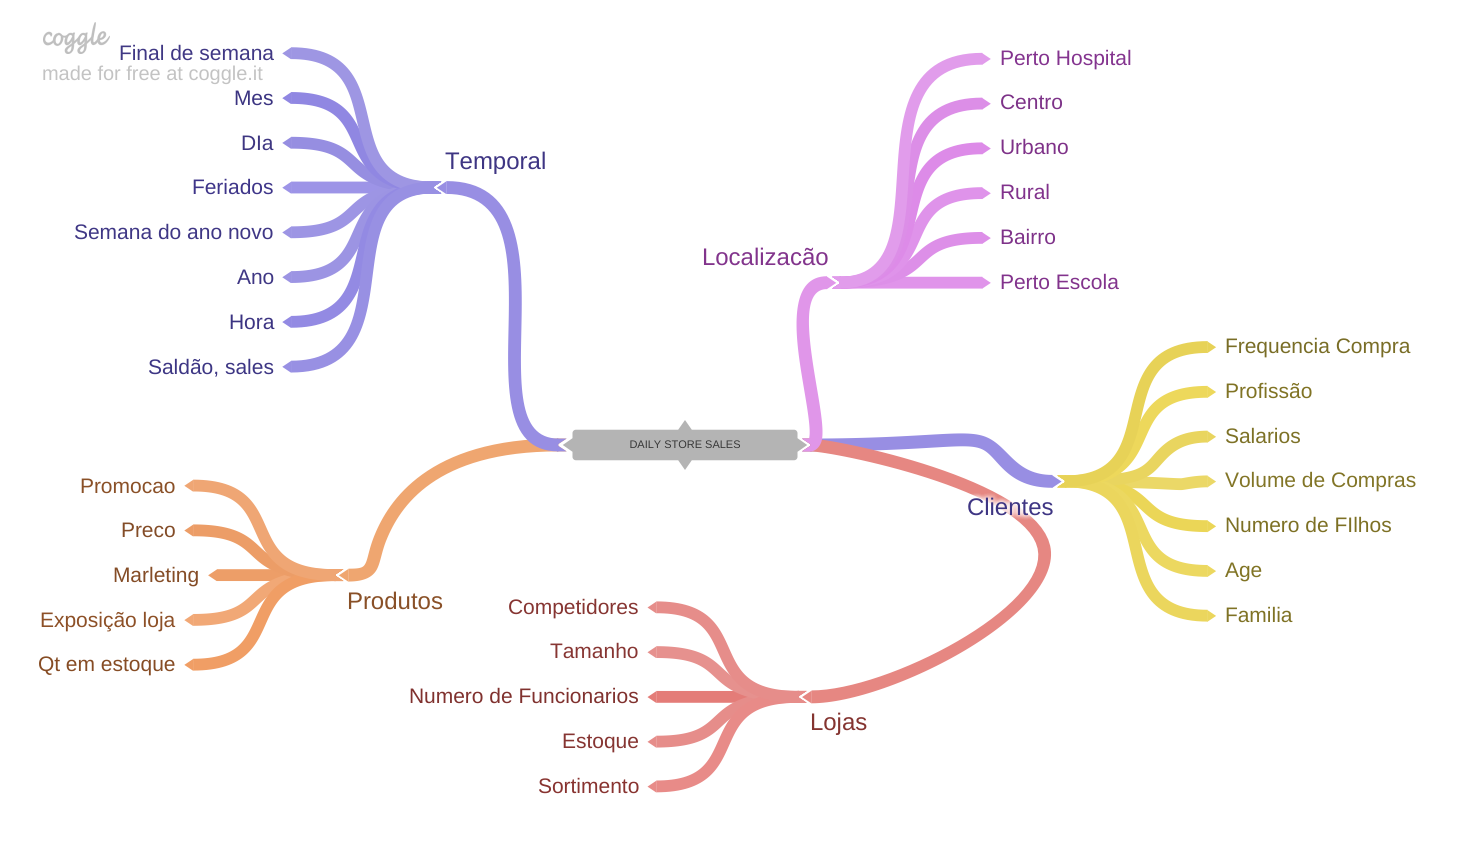

In [24]:
Image('image/DAILY_STORE_SALES.png')

### 2.1.1. Hipoteses loja

**1,** Lojas com maior quadro de funcionarios deveriam vender mais.

**2,** Lojas com maior estoque deveriam vender mais.

**3,** Lojas com maior porte deveriam vender mais.

**4,** Lojas com maior sortimentos deveriam vender mais.

**5,** Lojas com competidores mais proximos deveriam vender menos.

**6,** Lojas com competidores a mais tempo deveriam vender mais.

### 2.1.2. Hipotese Produto

**1,** Lojas que investem mais em Markentig deveriam vender mais.

**2,** Lojas que expoem mais o produto na vitrine deveriam vender mais.

**3,** Lojas que tem precos menores nos produtos deveriam vender mais.

**4,** Lojas que ter precos menores por mais tempo nos produtos deveriam vender mais

**5,** Lojas com promocoes mais agressivas (descontos maiores), deveriam vender mais.

**6,** Lojas com promocoes ativas por mais tempo deveriam vender mais.

**7,** Lojas com mais dias de promocao, deveriam vender mais.

**8,** Lojas com mais promocoes consecutivas deveriam vender mais.

### 2.1.3. Hipotese Tempo (Sazonalidade)

**1,** Lojas abertas durante o feriado de Natal, deveriam vender mais.

**2,** Lojas deveriam vender mais ao longo dos anos.

**3,** Lojas deveriam vender mais no segundo semestre do ano.

**4,** Lojas deveriam vender mais depois do dia 10 de cada mes.

**5,** Lojas deveriam vender menos aos finais de semana.

**6,** Lojas deveriam vender menos durante os feriados escolares.

In [ ]:
## 2.2. Lista final de Hipoteses


**1,** Lojas com maior sortimentos deveriam vender mais.

**2,** Lojas com competidores mais proximos deveriam vender menos.

**3,** Lojas com competidores a mais tempo deveriam vender mais.

**4,** Lojas com promocoes ativas por mais tempo deveriam vender mais.

**5,** Lojas com mais dias de promocao, deveriam vender mais.

**6,** Lojas com mais promocoes consecutivas deveriam vender mais.

**7,** Lojas abertas durante o feriado de Natal, deveriam vender mais.

**8,** Lojas deveriam vender mais ao longo dos anos.

**9,** Lojas deveriam vender mais no segundo semestre do ano.

**10,** Lojas deveriam vender mais depois do dia 10 de cada mes.

**11,** Lojas deveriam vender menos aos finais de semana.

**12,** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Feature engineering

In [54]:
#year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# week year
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )


# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30).apply( lambda x: x.days ).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = (( df2['date'] - df2['promo_since']) /7).apply( lambda x: x.days ).astype( int )

# assortment
# a = basic, b = extra, c = extended
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
# a = public_holiday, b = easter_holiday, c = christmas
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

# 3.0. PASSO 3 - Filtragem de variaveis

In [55]:
df3 = df2.copy()

In [56]:
df3.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [57]:
## 3.1. Filtragem das linhas

In [58]:
df3 = df3[(df3['open'] != 0 ) & (df3['sales'] > 0 ) ]

## 3.2. Select columns

In [59]:
cols_drop = [ 'customers', 'open', 'promo_interval', 'month_map' ]
df3 = df3.drop( cols_drop, axis=1 )

In [ ]:
df3.head()

# 4.0. PASSO 4 - Analise e exploracao dos dados

In [60]:
df4 = df3.copy()

## 4.1. Analise Univariada

### 4.1.1. Response variable 

/home/clever/.local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

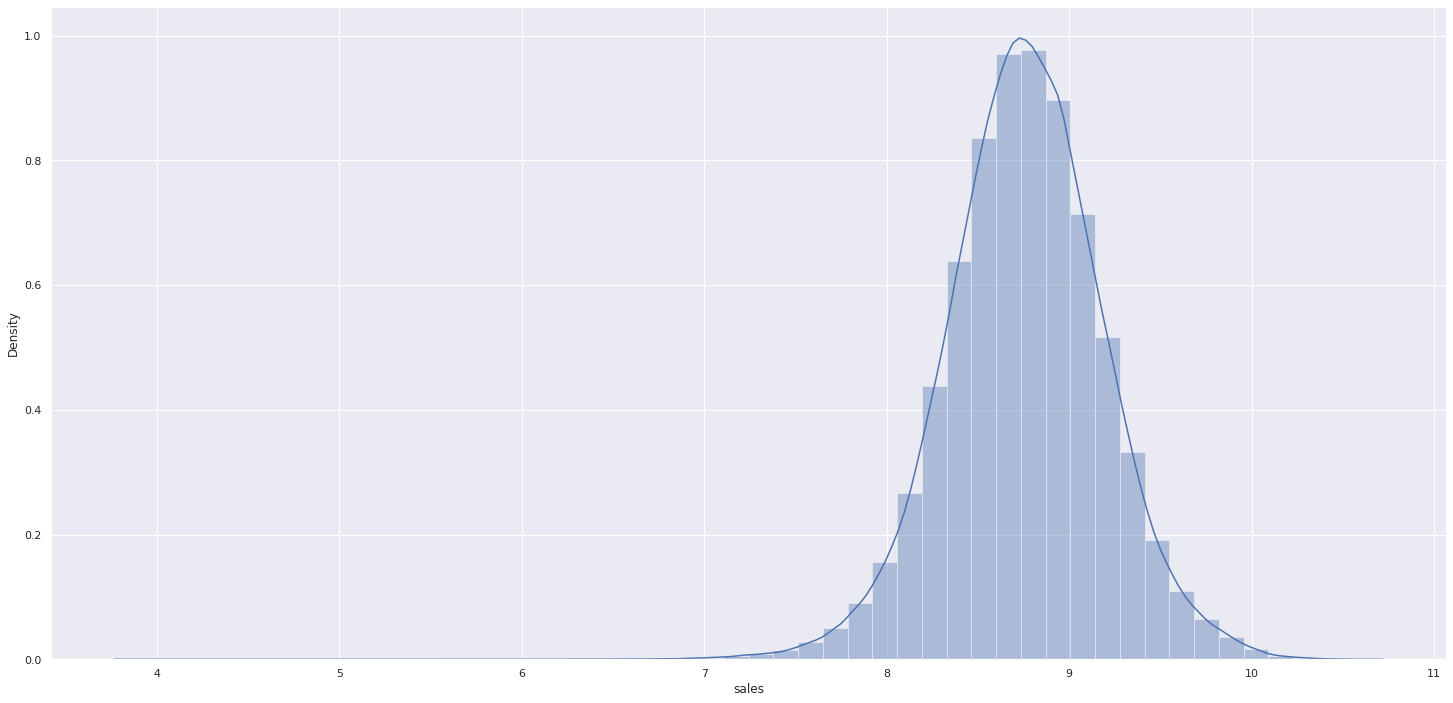

In [38]:
sns.distplot(np.log1p( df4['sales']))
# sns.distplot( df4['sales'])

### 4.1.2. Numerical variable

array([[<AxesSubplot:title={'center':'store'}>,
        <AxesSubplot:title={'center':'day_of_week'}>,
        <AxesSubplot:title={'center':'sales'}>,
        <AxesSubplot:title={'center':'customers'}>],
       [<AxesSubplot:title={'center':'open'}>,
        <AxesSubplot:title={'center':'promo'}>,
        <AxesSubplot:title={'center':'school_holiday'}>,
        <AxesSubplot:title={'center':'competition_distance'}>],
       [<AxesSubplot:title={'center':'competition_open_since_month'}>,
        <AxesSubplot:title={'center':'competition_open_since_year'}>,
        <AxesSubplot:title={'center':'promo2'}>,
        <AxesSubplot:title={'center':'promo2_since_week'}>],
       [<AxesSubplot:title={'center':'promo2_since_year'}>,
        <AxesSubplot:title={'center':'is_promo'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

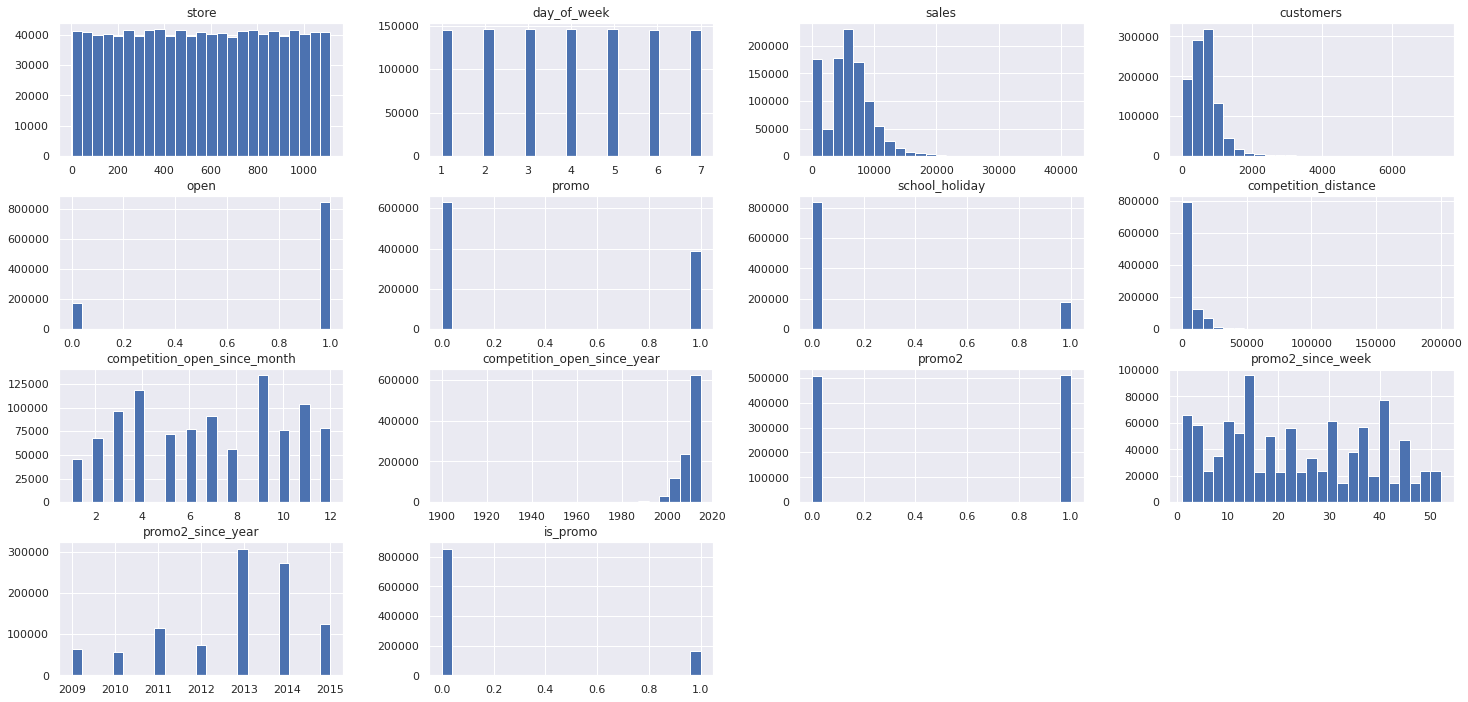

In [39]:
num_attributes.hist( bins=25 )

### 4.1.3 Categorical variable

In [40]:
df4['assortment'].drop_duplicates()

0      a
3      c
258    b
Name: assortment, dtype: object

/home/clever/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/clever/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/clever/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

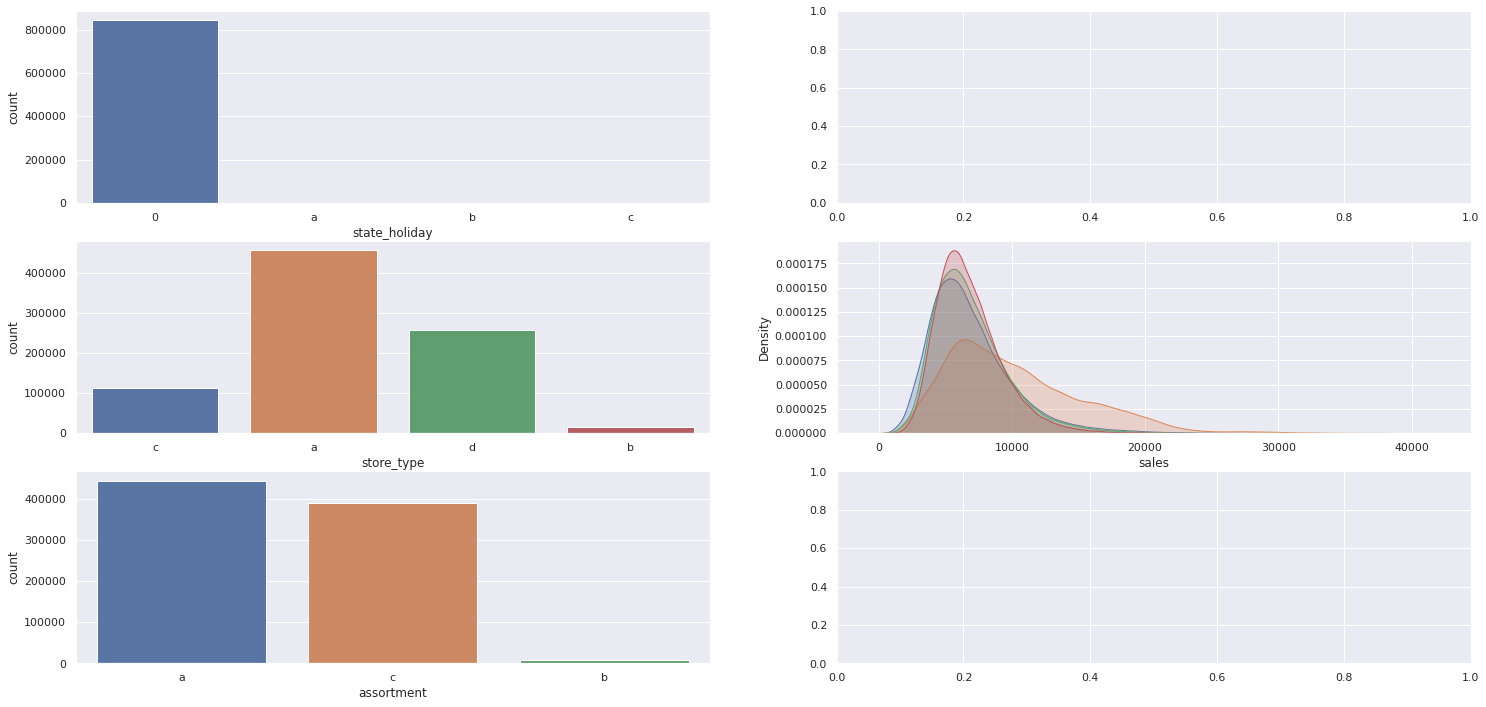

In [41]:
# state_holiday
plt.subplot( 3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )

plt.subplot( 3, 2, 2)
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas'     ]['sales'], label='christmas'     , shade=True )
# store_type
plt.subplot( 3, 2, 3)
sns.countplot( df4['store_type'] )

plt.subplot( 3, 2, 4)
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )

# assortment
plt.subplot( 3, 2, 5)
sns.countplot( df4['assortment'] )

plt.subplot( 3, 2, 6)
sns.kdeplot( df4[df4['assortment'] == 'basic'   ]['sales'], label='basic'   , shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra'   ]['sales'], label='extra'   , shade=True )

## 4.2. Analise bivariada

## 4.3. Analise multivarida

In [77]:
df4.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
is_promo                                 int64
year                                     int64
month                                    int64
day                                      int64
week_of_year                            UInt32
year_week                               object
competition_s

# 5.0. PASSO 5 - Preparacao dos dados

In [83]:
df5 = df4.copy()

In [84]:
## 5.1. Normalizacao

In [85]:
## 5.2. Rescaling

In [86]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump( rs, open( 'parameter/competition_distance_scaler.pk1', 'wb' ) )

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
pickle.dump( rs, open( 'parameter/competition_time_month_scaler.pk1', 'wb' ) )

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump( mms, open( 'parameter/promo_time_week_scaler.pk1', 'wb' ) )

# year
df5['year'] = mms.fit_transform( df5[['year']].values)
pickle.dump( mms, open( 'parameter/year_scaler.pk1', 'wb') )


/home/clever/.local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

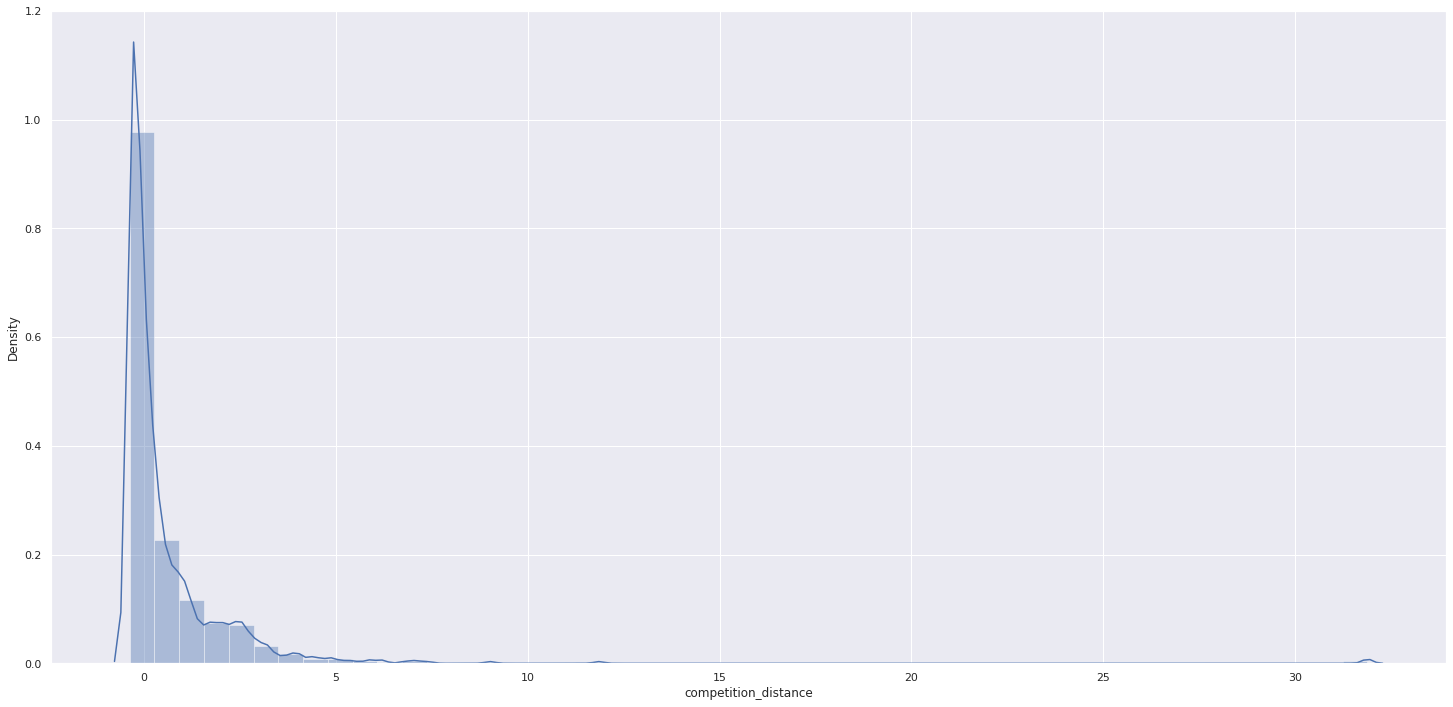

In [65]:
sns.distplot(df5['competition_distance'])

In [87]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,-0.170968,...,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,-0.283871,...,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,1.903226,...,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,-0.275806,...,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,4.448387,...,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016


## 5.3. Transformation

### 5.3.1. Encoding

In [88]:
# state_holiday - type - One HoT Encoding 
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'] )



# Store_type - Label_Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'])
pickle.dump( le, open('parameter/store_type_scaler.pw1', 'wb'))


# assortment - 
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.2. Response Variable Transforrmation

In [89]:
df5['sales'] = np.log1p( df5['sales'] ) #--- Pesquisar Log1p

### 5.3.3. Nature Transformation

In [101]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df5['month_sin']       = df5['month'].apply(lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos']       = df5['month'].apply(lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# Day
df5['day_sin']         = df5['day'].apply(lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos']         = df5['day'].apply(lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )


# 6.0. PASSO 6 - Feature selection

In [102]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test dataset

In [103]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week' ]
df6 = df6.drop( cols_drop, axis=1 )

In [104]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [95]:
## training and test dataset for Boruta
#X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
#y_train_n = y_train.values.ravel()
#
## define RandomForestRegressor
#rf = RandomForestRegressor( n_jobs=-1 )
#
## define Boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )

### 6.2.1 best features from Boruta

In [96]:
#cols_selected = boruta.support_.tolist()
#
## best features
#X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
#
## not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

## 6.3. Manual Feature Selector

In [105]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0. PASSO 7 - Machine learning modelling

In [106]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

## 7.1. Avarage Model

In [112]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2. Linear Regression Model

In [115]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1. Linear Regression Model - Cross validation

In [116]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3. Linear Regression Regularized Model - Lasso

In [117]:
# model
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1. Lasso - Cross validation

In [118]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
lrr_result_cv


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4. Random Forest Regressor

In [ ]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

### 7.4.1 Random Forest Regressor - Cross Validation

In [ ]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
rf_result_cv

## 7.5. XBoost Regressor

In [122]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100, 
                              eta=0.01, 
                              max_depth=10, 
                              subsample=0.7,
                              colsample_bytee=0.9 ).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,843.112293,0.122609,1250.952637


### 7.5.1. XBoost Regressor - Cross Validation

In [ ]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
xgb_result_cv

## 7.6. Compare Model's Performance

### 7.6.1. Single Performance

In [ ]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

In [ ]:
### 7.6.2. Real Performance - Cross Validation

In [ ]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv

# 8.0. PASSO 8 - Hiperparameter fine tuning 

## 8.1. Random Search

In [125]:
#param = {
#    'n_estimators': [1500, 1700, 2500, 3000, 3500],
#    'eta': [0.01, 0.03],
#    'max_depth': [3, 5, 9],
#    'subsample': [0.1, 0.5, 0.7],
#    'colsample_bytree': [0.3, 0.7, 0.9],
#    'min_child_weight': [3, 8, 15]
#        }
#
#MAX_EVAL = 5

In [124]:
#final_result = pd.DataFrame()
#
#for i in range( MAX_EVAL ):
#    # choose values for parameters randomly
#    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
#    print( hp )
#    
#    # model
#    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                  n_estimators=hp['n_estimators'], 
#                                  eta=hp['eta'], 
#                                  max_depth=hp['max_depth'], 
#                                  subsample=hp['subsample'],
#                                  colsample_bytee=hp['colsample_bytree'],
#                                  min_child_weight=hp['min_child_weight'] )
#
#    # performance
#    result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
#    final_result = pd.concat( [final_result, result] )
#        
#final_result

### 8.2. Final Model

In [126]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3 
        }

In [127]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'], 
                                    eta=param_tuned['eta'], 
                                    max_depth=param_tuned['max_depth'], 
                                    subsample=param_tuned['subsample'],
                                    colsample_bytee=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,664.974997,0.097529,957.774225


In [131]:
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
mpe

-0.0035453340418880653

# 9.0. PASSO 9 - Tradução e interpretação do erro

In [132]:
df9 = X_test[ cols_selected_boruta_full ]

# Rescale
df9[ 'sales'] = np.expm1(df9['sales'] )
df9[ 'predictions' ] = np.expm1( yhat_xgb_tuned )

## 9.1. Business Performance

In [133]:
# Sum of predictions
df91 = df9[[ 'store', 'predictions']].groupby( 'store').sum().reset_index()

# MAE e MAPE
df9_aux1 = df9[[ 'store', 'sales', 'predictions' ]].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE' } )  
df9_aux2 = df9[[ 'store', 'sales', 'predictions' ]].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'} )

# Merge MAE e MAPE
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge( df91, df9_aux3, how='inner', on='store')

# Scenarios
df92['worst_scenarios'] = df92['predictions'] - df92['MAE'] # Predicao do pior cenario
df92['best_scenarios' ] = df92['predictions'] + df92['MAE'] # Predicao do melhor cenario

# ordem columns
df92 = df92[[ 'store', 'predictions', 'worst_scenarios', 'best_scenarios', 'MAE', 'MAPE' ]] # Ordenacao das colunas


In [134]:
df92.sort_values( 'MAPE', ascending=False ).head()

,store,predictions,worst_scenarios,best_scenarios,MAE,MAPE
291,292,104033.085938,100714.981535,107351.190340,3318.104402,0.565828
908,909,238233.875000,230573.337254,245894.412746,7660.537746,0.520433
875,876,203030.156250,199110.952414,206949.360086,3919.203836,0.305099
721,722,353005.781250,351013.625119,354997.937381,1992.156131,0.268338
594,595,400883.625000,397415.263170,404351.986830,3468.361830,0.242192


<AxesSubplot:xlabel='store', ylabel='MAPE'>

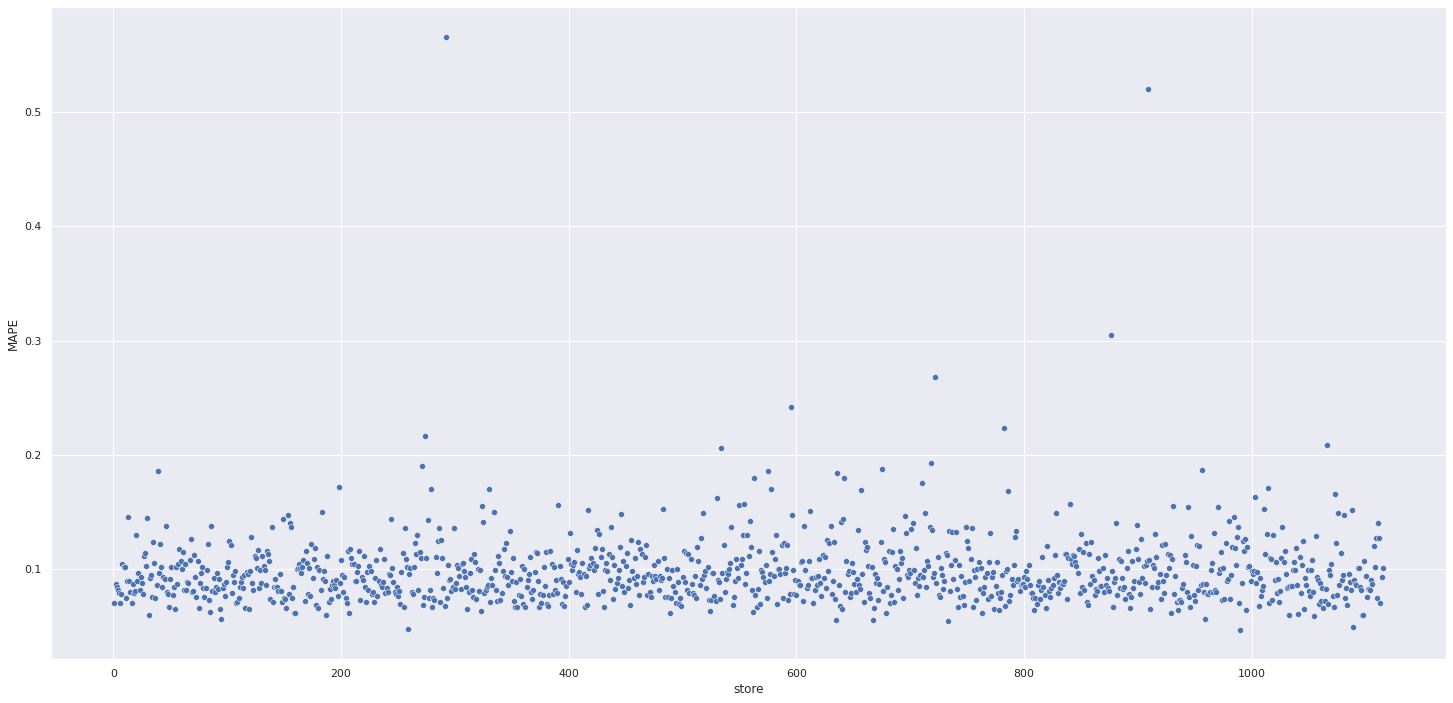

In [135]:
sns.scatterplot( x='store', y='MAPE', data=df92) # Visualizacao das lojas com MAPE mais alto e mais baixo

## 9.2. Total Performance

In [137]:
# forma de mostrar o valor real - 
df93 = df92[[ 'predictions', 'worst_scenarios', 'best_scenarios']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenarios', 0: 'Values' } )
df93[ 'Values'] = df93[ 'Values' ].map( 'R$ {:,.2f}'.format )
df93.head()

,Scenarios,Values
0,predictions,"R$ 285,860,480.00"
1,worst_scenarios,"R$ 285,115,015.78"
2,best_scenarios,"R$ 286,605,979.91"


## 9.3. Machine Learning

In [138]:
# Visualizando a performance do modelo

df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

<AxesSubplot:xlabel='predictions', ylabel='error'>

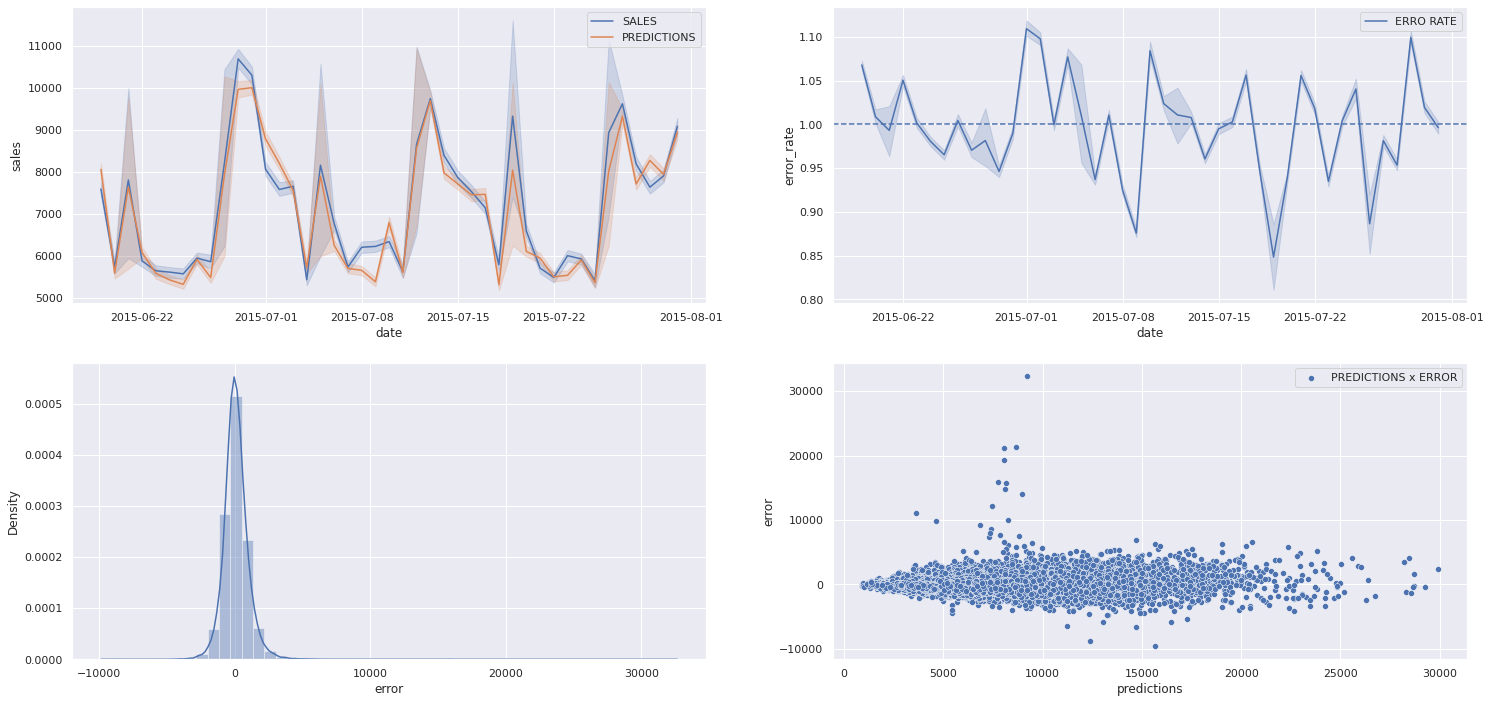

In [139]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES')
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9, label='ERRO RATE')
plt.axhline( 1, linestyle='--' ) # Se a variacao for acima do 1, entao eu tenho uma superextimacao,
                                 # Se for abaixo do 1, entao significa que as minhas predicoes sao menores que as vendas

plt.subplot( 2, 2, 3)
sns.distplot( df9['error'], label='ERROR') # Fala da distribuicao do erro, foi pego todos os erros que o modelo gerou.
                                           # Distribuicao proxima da Clausiana
                                           # Grafico muito usado em analise de residuos 
plt.subplot( 2, 2, 4)
sns.scatterplot( df9['predictions'], df9['error'], label='PREDICTIONS x ERROR' )
#  Grafico de analise de residuos, são as prediçõe em relação ao erro
#  Que sempre as previsões entre 8000 e 10000 sempre tem os erros maiores
#  Quanto maior o valor das previsões maior o erro
                                 

# 10.0. PASSO 10 - Deploy Model to prediction

## 10.1. Rossmann Class

In [142]:
# Save Trained Model
pickle.dump( model_xgb_tuned, open( 'model/model_rossmann.pk1', 'wb') )

In [143]:
import math
import pickle
import inflection
import pandas as pd
import numpy  as np
import datetime


class Rossmann( object ):
    def __init__( self ):
        self.home_path='/home/clever/repos/dsproducao/'
        self.competition_distance_scaler   = pickle.load( open( self.home_path + 'parameter/competition_distance_scaler.pk1', 'rb' ) )
        self.competition_time_month_scaler = pickle.load( open( self.home_path + 'parameter/competition_time_month_scaler.pk1', 'rb' ) )
        self.promo_time_week_scaler        = pickle.load( open( self.home_path + 'parameter/promo_time_week_scaler.pk1', 'rb' ) )
        self.year_scaler                   = pickle.load( open( self.home_path + 'parameter/year_scaler.pk1', 'rb') )
        self.store_type_scaler             = pickle.load( open( self.home_path + 'parameter/store_type_scaler.pw1', 'rb'))

    def data_cleaning( seft, df1 ):    
        

        cols_old = ['Store',
                    'DayOfWeek',
                    'Date',
                    #'Sales',    Não tem, pois preciso prever esses dados
                    #'Customers', Não tem, pois preciso prever esses dados
                    'Open',
                    'Promo',
                    'StateHoliday',
                    'SchoolHoliday',
                    'StoreType',
                    'Assortment',
                    'CompetitionDistance',
                    'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear',
                    'Promo2',
                    'Promo2SinceWeek',
                    'Promo2SinceYear',
                    'PromoInterval' ]

        snakecase = lambda x: inflection.underscore( x )

        cols_new = list( map( snakecase, cols_old ) )

        # rename
        df1.columns = cols_new

        ## 1.3. Data types

        df1['date'] = pd.to_datetime( df1['date'] ) # Transformacao do tipo da coluna - No caso 'Date'

        ## 1.5. Fillout NA

        # Removendo NA usando lambda

        # competition_distance
        df1[ 'competition_distance' ] = df1[ 'competition_distance' ].apply( lambda x: 200000.0 if math.isnan( x ) else x )
        # competition_open_since_month
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month']) else x['competition_open_since_month'], axis=1 )
        # competition_open_since_year
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year']) else x['competition_open_since_year'], axis=1 )
        # promo2_since_week             
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week']) else x['promo2_since_week'], axis=1 )
        # promo2_since_year         
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year']) else x['promo2_since_year'], axis=1 )
        # promo_interval


        # Criando uma Coluna Mes, e substituindo NA por 0
        month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dez'}

        df1['promo_interval'].fillna(0, inplace=True ) #Foi substituido NA por 0, nao retornando nenhum valor

        df1['month_map'] = df1['date'].dt.month.map( month_map ) #Transforma em data / mes / depois substitui os numeros por letras

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1 )


        ## 1.6. Change Types

        # Modificando o tipo dos dados por colunas
        #Competition
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year' ] = df1['competition_open_since_year' ].astype(int)

        # Promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
        
        return df1


    def feature_engineering( self, df2 ):
        

        #year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week

        # week year
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )


        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 )
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30).apply( lambda x: x.days ).astype(int)

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = (( df2['date'] - df2['promo_since']) /7).apply( lambda x: x.days ).astype( int )

        # assortment
        # a = basic, b = extra, c = extended
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        # state holiday
        # a = public_holiday, b = easter_holiday, c = christmas
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')



        # 3.0. PASSO 3 - Filtragem de variaveis

        ## 3.1. Filtragem das linhas
        df2 = df2[df2['open'] != 0 ]

        ## 3.2. Selecao das colunas
        cols_drop = [ 'open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1 )
        
        return df2

    def data_preparation( self, df5 ):
        
        ## 5.2. Rescaling


        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )

        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )
        
        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )
        
        # year
        df5['year'] = self.year_scaler.fit_transform( df5[['year_scaler']].values)

        ### 5.3.1. Encoding

        # state_holiday - type - One HoT Encoding 
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'] )

        # Store_type - Label_Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'])
        
        # assortment - 
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )
      

        ### 5.3.2. Nature Transformation

        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

        # day
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )
        
        cols_selected = [
                        'store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'month_sin',
                        'month_cos',
                        'day_sin',
                        'day_cos',
                        'week_of_year_sin',
                        'week_of_year_cos']

        return df5[ cols_selected ] 
    
    
    def get_prediction( self, model, original_data, test_data ):
        # Prediction
        pred = model.predict( test_data )
        
        # join pred into the original data
        original_data[ 'prediction' ] = np.expm1( pred )
        
        return original_data.to_json( orient='records', date_format='iso' )
    

## 10.2. API Handler

In [141]:
import pickle
import pandas as pd
from flask             import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load( open( '/model_rossmann.pkl', 'rb') )

# initialize API
app = Flask( __name__ )

@app.route( '/rossmann/predict', methods=['POST'] )
def rossmann_predict():
    test_json = request.get_json()
   
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Rossmann class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
        
        
    else:
        return Reponse( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '0.0.0.0' )

ModuleNotFoundError: No module named 'rossmann'

## 10.3. API Tester

In [144]:
import requests

In [145]:
df10 = pd.read_csv( 'datasets/test.csv')

In [154]:
# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

# choose store for prediction
df_test = df_test[df_test['Store'].isin( [20, 23, 22] )]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

In [155]:
# convert Dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [160]:
# API Call
# url = 'http://0.0.0.0:5000/rossmann/predict'
url = 'https://ds-prod-rossmann.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json' } 
data = data

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [161]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [162]:
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()

for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format( 
            d2.loc[i, 'store'], 
            d2.loc[i, 'prediction'] ) )

Store Number 20 will sell R$295,211.04 in the next 6 weeks
Store Number 22 will sell R$273,414.11 in the next 6 weeks
Store Number 23 will sell R$217,257.52 in the next 6 weeks
